In [1]:
import sys
sys.path.append('/content/drive/MyDrive/Glaucoma Detection')

# Optic Disk Region (Region of Interest) Detection

In [50]:
from imutils import contours
from skimage import measure
import numpy as np
import argparse
import imutils
import cv2
from google.colab.patches import cv2_imshow
import PIL

def point_check(pt):
  newpt = [0,0]
  newpt[0] = 0 if pt[0] < 0 else pt[0]
  newpt[1] = 0 if pt[1] < 0 else pt[1]
  return tuple(newpt)

In [80]:
from PIL import Image
import cv2

output_dim = 512
# img_path = "/content/drive/MyDrive/Glaucoma Detection/Dataset/Drishti/Training/Images/drishtiGS_045.png"
# img_path = "/content/drive/MyDrive/GUI/Predictions/IDRiD_12/IDRiD_12.jpg"
image = Image.open(img_path)
im_w, im_h = image.size
var = round(0.15 * im_w)
starting_threshold = 250

while True:
  # load the image, convert it to grayscale, and blur it
  image = cv2.imread(img_path)
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  blur = cv2.bilateralFilter(gray,9,75,75)
  median=cv2.medianBlur(gray,5)
  # cv2_imshow(median)

  # threshold the image to reveal light regions in the blurred image
  thresh = cv2.threshold(median, starting_threshold, 255, cv2.THRESH_BINARY)[1]

  # perform a series of erosions and dilations to remove any small blobs of noise from the thresholded image
  thresh = cv2.erode(thresh, None, iterations=2)
  thresh = cv2.dilate(thresh, None, iterations=4)
	# perform a connected component analysis on the thresholded image, then initialize a mask to store only the "large" components
  labels = measure.label(thresh, neighbors=8, background=0)
  mask = np.zeros(thresh.shape, dtype="uint8")
  print(np.unique(labels))

  largest_blob = 0
  # loop over the unique components
  for label in np.unique(labels):
    # if this is the background label, ignore it
    if label == 0:
      continue
    print("Creating mask")
    # otherwise, construct the label mask and count the number of pixels
    labelMask = np.zeros(thresh.shape, dtype="uint8")
    labelMask[labels == label] = 255
    numPixels = cv2.countNonZero(labelMask)
    # if the number of pixels in the component is sufficiently large, then add it to our mask of "large blobs"
    if numPixels > largest_blob:
      largest_blob = numPixels
      mask = labelMask

  # find the contours in the mask, then sort them from left to right
  cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  cnts = imutils.grab_contours(cnts)

  #If there is nothing found for the image
  if cnts == []:
    starting_threshold -= 10
    print("Decreasing threshold by 10. Now:", starting_threshold)
    continue

  cnts = contours.sort_contours(cnts)[0]

  for (i, c) in enumerate(cnts):
    (x, y, w, h) = cv2.boundingRect(c)

    center = (round(x+(w/2)), round(y+(h/2)))
    cv2.putText(image, "O", center, cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)
    box_radius = output_dim//2

    tl_pt = [center[0]-box_radius-50, center[1]-box_radius-100]
    br_pt = [center[0]+box_radius, center[1]+box_radius]

    #Check if TL point is out of bounds
    if tl_pt[0] < 0:
      neg = tl_pt[0] * -1
      tl_pt[0] = 0
      br_pt[0] += neg

    if tl_pt[1] < 0:
      neg = tl_pt[1] * -1
      tl_pt[1] = 0
      br_pt[1] += neg

    #Check if BR point is out of bounds
    if br_pt[0] > im_w:
      pos = im_w-br_pt[0]
      br_pt[0] = im_w
      tl_pt[0] -= pos

    if br_pt[1] > im_h:
      pos = im_h-br_pt[1]
      br_pt[1] = im_h
      tl_pt[1] -= pos

    cv2.rectangle(image,tuple(tl_pt) , tuple(br_pt), (255,0,0), 3)
    break
  print("Wid: ", br_pt[0]-tl_pt[0], "\tHei:", br_pt[1]-tl_pt[1])
  # image=cv2.resize(image,(512,512))
  image=cv2.resize(image,(im_w, im_h))
  cv2_imshow(image)
  break

In [81]:
img = np.asarray(Image.open(img_path))
print(img.shape)
tl_pt, br_pt

(1753, 2048, 3)


([493, 748], [1055, 1360])

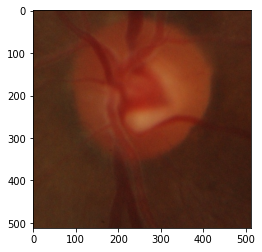

In [70]:
q = img[848:1360, 543:1055, :]
plt.imshow(q)